In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline

In [2]:
import bayesianchangepoint as bcp


## performing inference: application to experimental data


get your trump data:

https://github.com/bpb27/trump_tweet_data_archive

In [3]:
from io import BytesIO
from zipfile import ZipFile
import urllib.request
import json

datafile = 'trumpets.json'
datafile = '/tmp/trumpets.json'

try:
    with open(datafile, 'r') as f:
        data = json.load(f)
except:
    years = [8] #[2, 3, 4, 5, 6, 7]
    years = [6, 7]
    years = [2, 3, 4, 5, 6, 7, 8]
    data = []
    arctype = 'condensed'
    arctype = 'master'
    for year in years:
        url = urllib.request.urlopen("https://github.com/bpb27/trump_tweet_data_archive/blob/master/{arctype}_201{Y}.json.zip?raw=true".format(arctype=arctype, Y=str(year)))
        print('Downloading ', url, '...')
        with ZipFile(BytesIO(url.read())) as my_zip_file:
            for contained_file in my_zip_file.namelist():
                with my_zip_file.open(contained_file) as f:
                    #data.extend(json.load(f))
                    data.extend(json.loads(f.read().decode('utf-8')))
    with open(datafile, 'w') as f:
        json.dump(data, f)          

In [4]:
!ls -ltr /tmp/*json

-rw-r--r--  1 laurentperrinet  wheel  23269721 Mar 29 16:11 /tmp/trumpets.json


In [5]:
n_tweets = len(data)
print('number ow tweets=', n_tweets)

number ow tweets= 6830


## example tweet

In [6]:
i_sample = 42
i_sample = 1973
d = data[i_sample]
d#.keys()#['followers_count']

{'contributors': None,
 'coordinates': None,
 'created_at': 'Sun Jun 19 02:57:51 +0000 2016',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 25568,
 'favorited': False,
 'geo': None,
 'id': 744363535635996672,
 'id_str': '744363535635996672',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'place': {'attributes': {},
  'bounding_box': {'coordinates': [[[-179.231086, 13.182335],
     [179.859685, 13.182335],
     [179.859685, 71.434357],
     [-179.231086, 71.434357]]],
   'type': 'Polygon'},
  'contained_within': [],
  'country': 'United States',
  'country_code': 'US',
  'full_name': 'United States',
  'id': '96683cc9126741d1',
  'name': 'United States',
  'place_type': 'country',
  'url': 'https://api.twitter.com/1.1/geo/id/96683cc9126741d1.json'},
 'retweet_count': 7633,
 'r

## learning to handle datetimes

https://docs.python.org/3/library/datetime.html


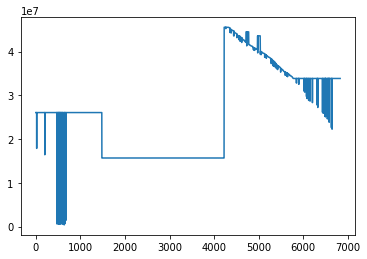

In [7]:
followers = [data[i]['user']['followers_count'] for i in range(n_tweets)]
plt.plot(followers);

In [8]:
data_texts = []
for i_tweet in range(n_tweets):
    try:
        data_texts.append(data[i_sample]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i_sample]['text'].lower())

data_texts[i_sample]

'how can the ny times show an empty room hours before my speech even started when they knew it was going to be packed? so totally dishonest!'

In [9]:
word = 'america'
word = '?'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')

6830 tweets contain the word " ? " on a total of  6830 tweets


In [10]:
datetimes = [data[i]['created_at'] for i in range(n_tweets)]
print('|'+datetimes[0]+'|')

|Sat Dec 31 18:59:04 +0000 2016|


In [11]:
import locale
locale.getlocale()

('en_US', 'UTF-8')

In [12]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1483210744.0


In [13]:
from datetime import datetime

datetimes = np.array([datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y').timestamp() for i in range(n_tweets)])
print('Timestamp=', (datetimes[0]))

Timestamp= 1483210744.0


In [14]:
from datetime import datetime

datetimes = [datetime.strptime(data[i]['created_at'], '%a %b %d %H:%M:%S %z %Y') for i in range(n_tweets)]
print('Timestamp=', datetimes[0].timestamp())

Timestamp= 1483210744.0


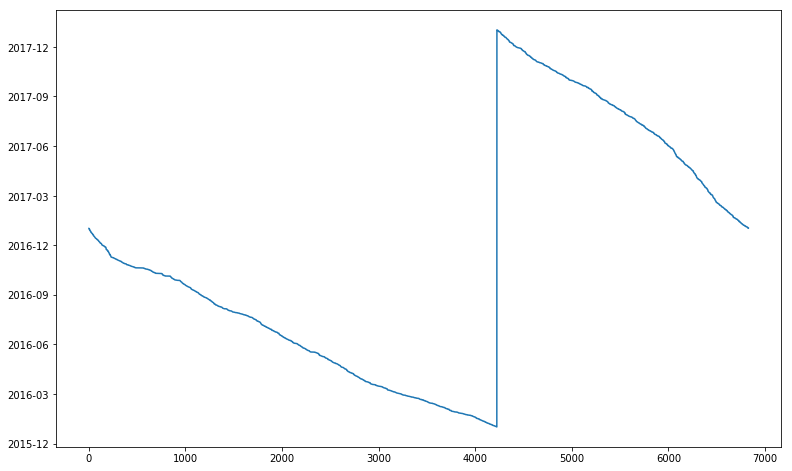

In [15]:
fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes);

It seems that within each year, tweets are in inverse chronological order. 
Let's sort things:

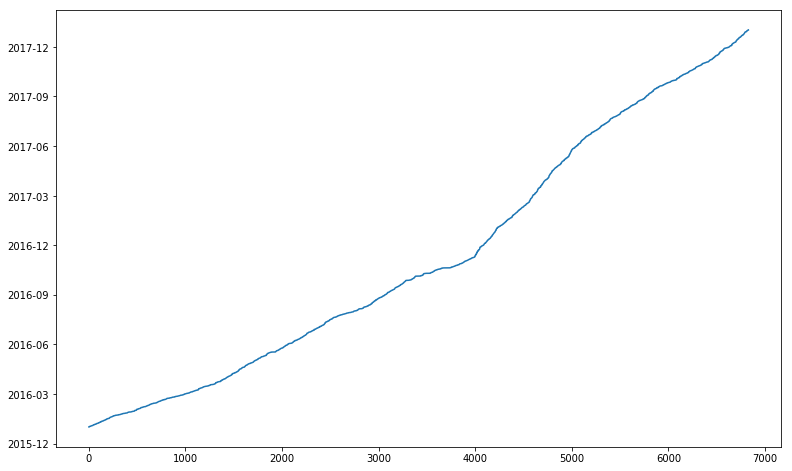

In [16]:
datetimes = np.array(datetimes)
ind_tweets = np.argsort(datetimes)

fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes[ind_tweets]);

We will be using https://matplotlib.org/examples/api/date_demo.html

## evolution of followers

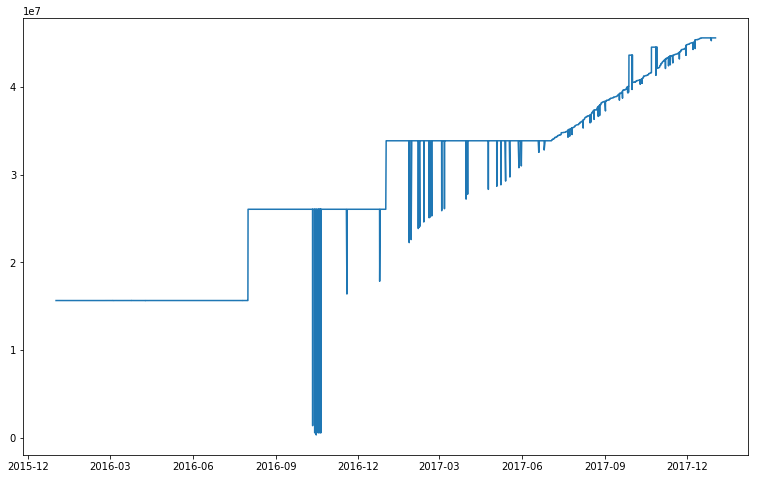

In [17]:
followers = np.array([data[i]['user']['followers_count'] for i in range(n_tweets)])

fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))
ax.plot(datetimes[ind_tweets], followers[ind_tweets]);

In [18]:
i= 42
data_texts = []
for i in range(n_tweets):
    try:
        data_texts.append(data[i]['full_text'].lower())
    except KeyError:
        data_texts.append(data[i]['text'].lower())

data_texts[i]

'to all americans-\n#happynewyear &amp; many blessings to you all! looking forward to a wonderful &amp; prosperous 2017 as we… https://t.co/1asdmal4iy'

In [19]:
word = 'america'
contains_word = np.array([(word in data_text) for data_text in data_texts])
print(sum(contains_word), 'tweets contain the word "', word, '" on a total of ', n_tweets, 'tweets')
p0 = sum(contains_word) / n_tweets
print('That is, an average probability of p0= ', p0)

1075 tweets contain the word " america " on a total of  6830 tweets
That is, an average probability of p0=  0.15739385065885797


## detecting change points



In [20]:
h = 1/1000
max_run_length = int(3/h)
p0 = sum(contains_word) / n_tweets

In [21]:
p_bar, r, beliefs = bcp.inference(contains_word[ind_tweets], h=h, p0=p0)

NameError: name 'years' is not defined

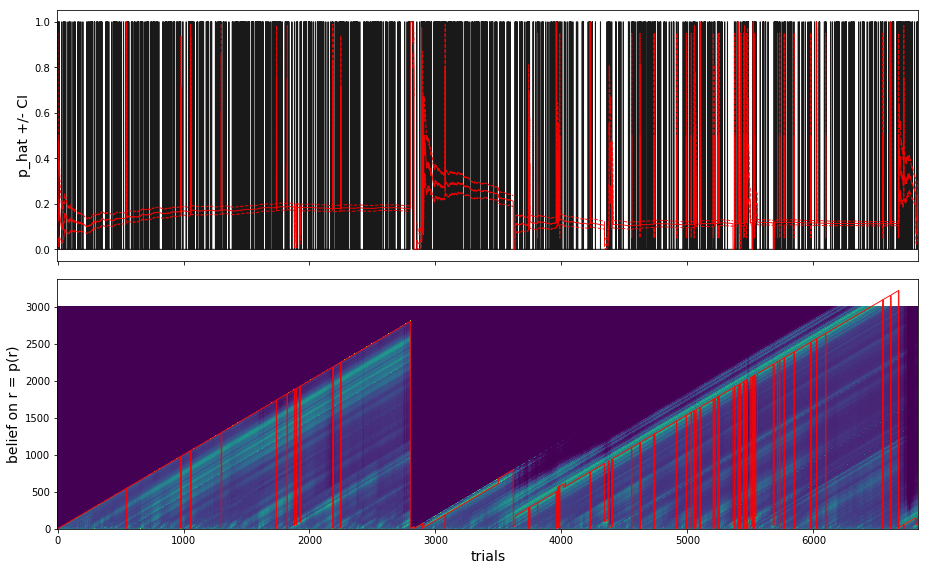

In [22]:
fig, axs = bcp.plot_inference(contains_word[ind_tweets], None, p_bar, r, beliefs, mode='max', max_run_length=max_run_length)
ax = axs[-1]
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

## wraping things up

In [ ]:
import datetime
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
fig_width = 13
fig, ax = plt.subplots(figsize=(fig_width, fig_width/1.6180))


for word, c in zip(['?', '!', 'america'], ['b', 'r', 'o']): 
    
    contains_word = np.array([(word in data_text) for data_text in data_texts])
    p0 = sum(contains_word) / n_tweets
    
    p_bar, r, beliefs = bcp.inference(contains_word[ind_tweets], h=h, p0=p0)
    
    p_hat, r_hat = bcp.readout(p_bar, r, beliefs)#, mode='max')

    ax.plot(datetimes[ind_tweets], p_hat, c=c, label=word)
    #ax.plot(datetimes)


    #datemin = datetime.date(datetimes.min(), 1, 1)
    #datemax = datetime.date(datetimes.max() + 1, 1, 1)
    #ax.set_xlim(datemin, datemax)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    #ax.set_yscale('log')
ax.set_xlabel('Date')
ax.set_ylabel('Estimated probability')    
ax.legend(loc='best')